## Leveraging schemas for reproducible biomedical data analysis using lamindb
---

In this tutorial, we will use LaminDB to enhance the organization and reproducibility of an ML analysis. Specifically, we will explore:

- The role of schemas in maintaining dataset consistency
- The importance of features and labels in structuring biological data
- How to create and register features and labels in LaminDB
- Enforcing schema adherence to improve findability and interoperability
- How structured data management streamlines the analysis workflow

To resemble the multiple stages a dataset is processed in, we've split this into multiple notebooks:

- Introduction and querying raw data
- Preprocessing Raw data and some EDA
- ML Analysis and biological interpretation

By the end, you'll learn how to curate and structure biological datasets using LaminDB, enabling seamless integration of multiple experiments, improving dataset discoverability, and maintaining an efficient, reproducible data analysis pipeline.

### Finding genetic drivers of breast cancer metastasis
---
**Our objective**: Investigate the molecular changes associated with lymph node metastasis in breast cancer using scRNA-seq. By analyzing matched primary breast cancer (PC) tumors and lymph node (LN) metastases from five patients, the study aims to identify key transcriptional differences between primary and metastatic sites. The analysis can be used as a starting point to uncover potential biomarkers, pathways, and cellular programs that drive the transition from primary tumors to metastatic disease in the lymph nodes.

**Our dataset**: Single-cell RNA sequencing reveals the mechanism of human breast cancer metastasis

**Reference**: [Xu K, Wang R, Chen Q, Liu Y et al. Microenvironment components and spatially resolved single-cell transcriptome atlas of breast cancer metastatic axillary lymph nodes.](https://www.sciengine.com/ABBS/doi/10.3724/abbs.2022131) 

Instead of manually retrieving files, users can simply search for the raw artifact in the LaminDB Artifacts Registry and load the data seamlessly, ensuring consistency and reproducibility in the workflow. Here, we will create an AnnData object from the raw data and register it as an artifact, making it easily accessible for downstream analysis.

In [1]:
import lamindb as ln
import bionty as bt

→ connected lamindb: laminlabs/lamindata


In [10]:
import os
from pathlib import Path
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy.sparse as sp
from tqdm import tqdm

### We can create a project for our entire analysis steps
---
 In a Project we can link the entities created during a run.

In [12]:
project = ln.Project(name="Breast metastasis").save()

In [13]:
ln.Project.df()

,uid,name,is_type,abbr,url,start_date,end_date,_status_code,space_id,type_id,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,
3,9M7iVOgQ8VAQ,Breast metastasis,False,None,None,None,None,0,1,None,NaN,2025-03-23 09:46:42.981520+00:00,35,None,1
2,e6VampLs53qm,Breast Cancer scRNA-seq Project,False,None,None,None,None,0,1,None,536.0,2025-03-20 20:56:44.652524+00:00,35,None,1
1,gmRj8xJNQY11,Test project,False,None,None,None,None,0,1,None,NaN,2025-03-10 12:02:20.234111+00:00,9,None,1


In [2]:
ln.track(project="Breast metastasis")

→ created Transform('porDxHS9GLB60000'), started new Run('WuvgoTQB...') at 2025-03-23 11:08:38 UTC
→ notebook imports: anndata==0.11.3 bionty==1.1.2 lamindb==1.3.0 pandas==2.2.3 scanpy==1.11.0 scipy==1.15.2 tqdm==4.67.1


#### Lets have a look at the AnnData Object

In [ ]:
adata_artifact = ln.Artifact.get("grmr98C4DvA2ofeP0000") 

In [5]:
adata_artifact.key = 'schema/raw_adata.h5ad'
adata_artifact.save()


Artifact(uid='grmr98C4DvA2ofeP0000', is_latest=True, key='schema/raw_adata.h5ad', description='Single Cell RNA-seq dataset from GEO [GSE180286], RAW-Counts', suffix='.h5ad', otype='AnnData', size=982219738, hash='q4mdUBZZH_DE65t29RY5UG', n_observations=117481, space_id=1, storage_id=2, run_id=536, created_by_id=35, created_at=2025-03-20 20:49:35 UTC)

In [6]:
adata = adata_artifact.load()
adata

AnnData object with n_obs × n_vars = 117481 × 17872
    obs: 'patient', 'site'

In [15]:
adata.var.head()

""
UQCR10
SPP1
HLA-DPB1
MT-RNR2
RPS29


In [16]:
adata.obs.head()

,patient,site
GGATAAGGGTCA-0,P1,primary
CCGTGCGTACTG-0,P1,primary
AGGTAACCTACG-0,P1,primary
CTGTATAACCTA-0,P1,primary
AAACAGGTTTGA-0,P1,primary


In [9]:
adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'grmr98C4DvA2ofeP0000'
│   ├── .key = 'schema/raw_adata.h5ad'
│   ├── .size = 982219738
│   ├── .hash = 'q4mdUBZZH_DE65t29RY5UG'
│   ├── .n_observations = 117481
│   ├── .path = s3://lamindata/.lamindb/grmr98C4DvA2ofeP0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-20 21:49:35
│   └── .transform = 'Schema_001_V4.ipynb'
└── Labels
    └── .projects                   Project                    Breast metastasis                        
        .tissues                    bionty.Tissue              lymph node, breast                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Raw

### We can annotate our Artifact with labels and Features
---

#### Labels

In [10]:
# Data status represents Raw or Filtered Data
processing_stage = ln.ULabel(name="Processing Stage", is_type=True).save()

→ returning existing ULabel record with same name: 'Processing Stage'


In [ ]:
# Add Raw as ULabel
raw_status = ln.ULabel(
    name="Raw", type=processing_stage
).save()

## Add Filtered as ULabel
filtered_status = ln.ULabel(
    name="Filtered", type=processing_stage
).save()

→ returning existing ULabel record with same name: 'Raw'
→ returning existing ULabel record with same name: 'Filtered'


In [12]:
# We can now add this raw Label to the artifact
adata_artifact.ulabels.add(raw_status)

In [13]:
adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'grmr98C4DvA2ofeP0000'
│   ├── .key = 'schema/raw_adata.h5ad'
│   ├── .size = 982219738
│   ├── .hash = 'q4mdUBZZH_DE65t29RY5UG'
│   ├── .n_observations = 117481
│   ├── .path = s3://lamindata/.lamindb/grmr98C4DvA2ofeP0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-20 21:49:35
│   └── .transform = 'Schema_001_V4.ipynb'
└── Labels
    └── .projects                   Project                    Breast metastasis                        
        .tissues                    bionty.Tissue              lymph node, breast                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Raw

Similary we can add ULabels from bionty registry

In [26]:
# Tissue
tissue_breast = bt.Tissue.from_source(name="breast").save()
tissue_lymph = bt.Tissue.from_source(name="lymph node").save()

adata_artifact.tissues.add(tissue_breast)
adata_artifact.tissues.add(tissue_lymph)

#### Features

We can also annotate datasets by features.

In [23]:
ln.Feature(name="disease", dtype=bt.Disease).save()
ln.Feature(name="author", dtype=str).save()

→ returning existing Feature record with same name: 'disease'
→ returning existing Feature record with same name: 'author'


Feature(uid='BGdZm2yQneIq', name='author', dtype='str', array_rank=0, array_size=0, space_id=1, created_by_id=35, run_id=536, created_at=2025-03-20 22:22:10 UTC)

In [ ]:
# we can now annotate our artifact
adata_artifact.features.add_values(
    {
        "author": "Xu K"
    }
)

In [27]:
adata_artifact.describe()

Artifact .h5ad/AnnData
├── General
│   ├── .uid = 'grmr98C4DvA2ofeP0000'
│   ├── .key = 'schema/raw_adata.h5ad'
│   ├── .size = 982219738
│   ├── .hash = 'q4mdUBZZH_DE65t29RY5UG'
│   ├── .n_observations = 117481
│   ├── .path = s3://lamindata/.lamindb/grmr98C4DvA2ofeP0000.h5ad
│   ├── .created_by = paupaiz
│   ├── .created_at = 2025-03-20 21:49:35
│   └── .transform = 'Schema_001_V4.ipynb'
├── Linked features
│   └── disease                     cat[bionty.Disease]        breast cancer                            
│       author                      str                        Xu K                                     
└── Labels
    └── .projects                   Project                    Breast metastasis                        
        .tissues                    bionty.Tissue              lymph node, breast                       
        .diseases                   bionty.Disease             breast cancer                            
        .ulabels                    ULabel                     Raw

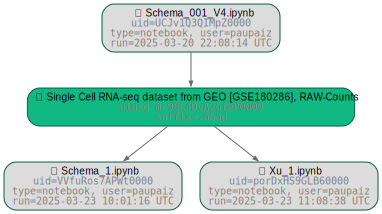

In [28]:
adata_artifact.view_lineage()

### Search and Query the dataset
---
with our artifact well annotated we can now easily search for it in the registry

In [29]:
ln.Artifact.features.filter(author__contains="Xu K").df()

,uid,key,description,suffix,kind,otype,size,hash,n_files,n_observations,_hash_type,_key_is_virtual,_overwrite_versions,space_id,storage_id,schema_id,version,is_latest,run_id,created_at,created_by_id,_aux,_branch_code
id,,,,,,,,,,,,,,,,,,,,,,,
1381,grmr98C4DvA2ofeP0000,schema/raw_adata.h5ad,Single Cell RNA-seq dataset from GEO [GSE18028...,.h5ad,None,AnnData,982219738,q4mdUBZZH_DE65t29RY5UG,None,117481,sha1-fl,True,False,1,2,None,None,True,536,2025-03-20 20:49:35.851408+00:00,35,None,1


In [31]:
ln.finish()

! cells [(1, 10), (10, 12), (13, 2), (2, None), (None, 5), (6, 15), (16, 9), (10, None), (None, 12), (13, 26), (26, 23), (24, 27)] were not run consecutively
→ finished Run('WuvgoTQB') after 25m at 2025-03-23 11:33:51 UTC
→ go to: https://lamin.ai/laminlabs/lamindata/transform/porDxHS9GLB60000
→ to update your notebook from the CLI, run: lamin save /Users/paulinampaiz/Desktop/myLamin_local/Xu_1.ipynb
